In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import pickle
import gzip

with gzip.open(("/content/gdrive/My Drive/Colab Notebooks/Modal_VAE/mnist/mnist.pkl.gz"), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

(50000, 784)


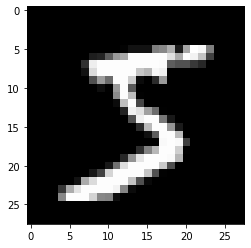

In [4]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

In [0]:
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [0]:
train_size = x_train.shape[0]
train_data = torch.tensor(x_train, device=dev).reshape(train_size, 28, 28).unsqueeze(1)
train_target = torch.tensor(y_train, device=dev)

valid_size = x_valid.shape[0]
valid_data = torch.tensor(x_valid, device=dev).reshape(valid_size, 28, 28).unsqueeze(1)
valid_target = torch.tensor(y_valid, device=dev)

In [0]:
bs = 500

In [0]:
train_ds = TensorDataset(train_data, train_data)
valid_ds = TensorDataset(valid_data, valid_data)

In [0]:
train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, 2*bs)

In [0]:
class VAE(nn.Module):
    def __init__(self, channels, dim_h, dim_z):
        super(VAE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 1, (2,2), stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(1, 1, (2,2), stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(1, 1, (2,2), stride=1, padding=0),        
        )
        
        self.p1 = nn.Linear(dim_h, dim_z)
        self.p2 = nn.Linear(dim_h, dim_z)
        
        self.decoder = nn.Sequential(
            nn.BatchNorm2d(1),
            nn.ConvTranspose2d(1, 1, (2,2), stride=2, padding=0),            
            nn.ReLU(),
            nn.ConvTranspose2d(1, 1, (3,3), stride=2, padding=0),
            nn.BatchNorm2d(1),
            nn.ReLU(),
            nn.ConvTranspose2d(1, 1, (4,4), stride=1, padding=0),
            nn.BatchNorm2d(1),
            nn.ConvTranspose2d(1, 1, (2,2), stride=1, padding=0),
            nn.BatchNorm2d(1),
            nn.ConvTranspose2d(1, 1, (2,2), stride=1, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(1, 1, (3,3), stride=1, padding=0),
            nn.BatchNorm2d(1),
            nn.ConvTranspose2d(1, 1, (3,3), stride=1, padding=0),
            nn.BatchNorm2d(1),
            nn.ConvTranspose2d(1, 1, (3,3), stride=1, padding=0)
        )

        self.bn1 = nn.BatchNorm2d(1)
        self.bn2 = nn.BatchNorm2d(1)
    
    def encode(self, in_data):
        h = self.encoder(in_data)
        h = h.reshape(h.shape[0], -1)

        #mu = self.p1(h)
        #log_var = self.p2(h)
        h = self.p1(h)
        mu, log_var = torch.split(h, 16, 1)
        
        #sampling and reparameterization for backprop
        z = torch.rand(mu.shape, device = dev)
        z = mu + torch.exp(log_var) * z
        z = z.reshape(z.shape[0], 1, 4, 4)
        return z, mu, log_var
    
    def decode(self, h_data):
        z = self.decoder(h_data)
        return z
                
    def forward(self, in_data):
        z, mu, log_var = self.encode(in_data)

        z = self.decode(z)
        return z, mu, log_var        

In [0]:
model_vae = VAE(11, 36, 32).to(dev)

In [0]:
#Kullback–Leibler divergence for N(mu, var^2) and N(0, I)
def kl_divergence(mu, log_var):
    return 0.5*( torch.sum( log_var.exp(), 1) + torch.sum(mu*mu, 1) - mu.shape[1] - torch.sum(log_var, 1) )

In [0]:
#(MSE loss + Kullback–Leibler divergence) / batch
def vae_loss(mu, log_var, pred, target):
    bs = pred.shape[0]
    kl_loss = kl_divergence(mu, log_var).mean()
    mse_loss = F.l1_loss(pred, target, reduction = 'sum') / bs
    return (kl_loss + mse_loss)

In [0]:
lr = 0.001

In [0]:
loss_func = vae_loss
opt = torch.optim.Adam(model_vae.parameters(), lr)

In [0]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for data, target in train_dl:
            pred, mu, log_var = model(data)
            loss = loss_func(mu, log_var, pred, target)
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        model.eval()
        with torch.no_grad():
            average_valid_loss = torch.zeros(1)
            l1_loss = torch.zeros(1)
            num_batch = 0
            for data, target in valid_dl:
                pred, mu, log_var = model(data)
                average_valid_loss += loss_func(mu, log_var, pred, target)
                num_batch += 1
                l1_loss += F.l1_loss(pred, target, reduction='sum')
            average_valid_loss /= num_batch
            l1_loss /= (bs * num_batch)
            print("Epoch: " + str(epoch) + "  L1 + KL-divergence: " + str(average_valid_loss) + "  L1-loss: " + str(l1_loss))

In [0]:
epochs = 100

In [248]:
fit(epochs, model_vae, loss_func, opt, train_dl, valid_dl)

Epoch: 0  L1 + KL-divergence: tensor([75.4181])  L1-loss: tensor([145.2146])
Epoch: 1  L1 + KL-divergence: tensor([72.6655])  L1-loss: tensor([139.6529])
Epoch: 2  L1 + KL-divergence: tensor([73.8619])  L1-loss: tensor([142.0478])
Epoch: 3  L1 + KL-divergence: tensor([73.2731])  L1-loss: tensor([140.8357])
Epoch: 4  L1 + KL-divergence: tensor([74.8062])  L1-loss: tensor([143.9437])
Epoch: 5  L1 + KL-divergence: tensor([79.0089])  L1-loss: tensor([152.3104])
Epoch: 6  L1 + KL-divergence: tensor([76.7373])  L1-loss: tensor([147.7268])
Epoch: 7  L1 + KL-divergence: tensor([77.2409])  L1-loss: tensor([148.6906])
Epoch: 8  L1 + KL-divergence: tensor([78.3884])  L1-loss: tensor([151.0256])
Epoch: 9  L1 + KL-divergence: tensor([72.1967])  L1-loss: tensor([138.6041])
Epoch: 10  L1 + KL-divergence: tensor([78.0018])  L1-loss: tensor([150.2421])
Epoch: 11  L1 + KL-divergence: tensor([73.6514])  L1-loss: tensor([141.4818])
Epoch: 12  L1 + KL-divergence: tensor([76.2402])  L1-loss: tensor([146.644

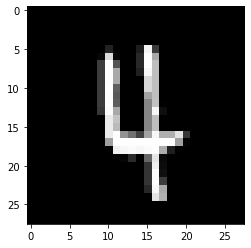

In [285]:
pyplot.imshow(x_valid[9].reshape((28, 28)), cmap="gray")

In [0]:
result, mu, log_var = model_vae(valid_data[9].unsqueeze(0))

In [0]:
x_result= result[0,0]

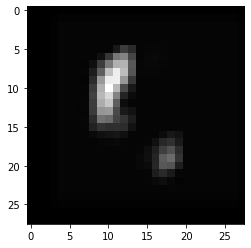

In [288]:
pyplot.imshow(x_result.cpu().detach().numpy(), cmap="gray")

In [0]:
torch.save(model_vae.state_dict(), "/content/gdrive/My Drive/Colab Notebooks/Modal_VAE/vae_mnist")